In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score, confusion_matrix
import pickle

In [2]:
dataset=pd.read_csv('dataset_churn.csv')

#undestanding the dataset:

In [3]:
dataset.head()

Unnamed: 0                            CustomerID   Age  Gender  Tenure  \
0           0  08729464-bde6-43bc-8f63-a357096feab1  56.0    Male      13   
1           1  af95bc95-baf4-4318-a21d-70d2ea3148b7  69.0    Male      13   
2           2  1fe7eee6-2227-4400-9998-4d993f4a60fd  46.0    Male      60   
3           3  f736fe7b-1b44-4acd-84c2-21c4aef648be  32.0  Female      57   
4           4  4b40d12d-7633-4309-96b8-aee675ea20ae  60.0    Male      52   

  Service_Internet Service_Phone Service_TV        Contract     PaymentMethod  \
0              DSL           Yes         No        One year      Mailed check   
1              DSL            No        Yes        Two year      Mailed check   
2      Fiber optic            No        Yes  Month-to-month      Mailed check   
3      Fiber optic           Yes        Yes  Month-to-month     Bank transfer   
4      Fiber optic           Yes        Yes        Two year  Electronic check   

   MonthlyCharges  TotalCharges StreamingMovies StreamingMusic OnlineSecurity  \
0           71.88        931.49              No             No            Yes   
1          110.99       1448.46             Yes            Yes             No   
2          116.74       6997.73             Yes            Yes             No   
3           78.16       4452.13              No            Yes             No   
4           30.33       1569.73             Yes             No            Yes   

  TechSupport Churn  
0          No    No  
1          No    No  
2          No    No  
3         Yes    No  
4         Yes    No

In [4]:
dataset.columns = dataset.columns.str.strip()

In [5]:
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.drop(columns=['CustomerID'])

In [6]:
dataset.columns

Index(['Age', 'Gender', 'Tenure', 'Service_Internet', 'Service_Phone',
       'Service_TV', 'Contract', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'StreamingMovies', 'StreamingMusic', 'OnlineSecurity',
       'TechSupport', 'Churn'],
      dtype='object')

In [7]:
dataset.shape

(3749, 15)

In [8]:
dataset.describe()

Age       Tenure  MonthlyCharges  TotalCharges
count  3562.000000  3749.000000     3749.000000   3749.000000
mean     43.655531    36.264070       75.844318   2718.968266
std      14.914474    20.505528       73.062971   3211.879149
min      18.000000     1.000000       20.000000     13.190000
25%      31.000000    19.000000       44.570000   1076.240000
50%      44.000000    36.000000       69.590000   2132.260000
75%      56.000000    54.000000       95.540000   3619.710000
max      69.000000    71.000000     1179.300000  79951.800000



#dataset Preprocessing

In [9]:
dataset.isnull().sum()

Age                 187
Gender                0
Tenure                0
Service_Internet    721
Service_Phone         0
Service_TV            0
Contract              0
PaymentMethod       187
MonthlyCharges        0
TotalCharges          0
StreamingMovies       0
StreamingMusic        0
OnlineSecurity        0
TechSupport           0
Churn                 0
dtype: int64

In [10]:
imputer_median = SimpleImputer(strategy='median')
dataset['Age'] = imputer_median.fit_transform(dataset[['Age']]).ravel()

imputer_mode = SimpleImputer(strategy='most_frequent')
dataset['PaymentMethod'] = imputer_mode.fit_transform(dataset[['PaymentMethod']]).ravel()

dataset['Service_Internet'] = imputer_mode.fit_transform(dataset[['Service_Internet']]).ravel()

dataset.isnull().sum()

Age                 0
Gender              0
Tenure              0
Service_Internet    0
Service_Phone       0
Service_TV          0
Contract            0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
StreamingMovies     0
StreamingMusic      0
OnlineSecurity      0
TechSupport         0
Churn               0
dtype: int64

In [11]:
dataset.dtypes

Age                 float64
Gender               object
Tenure                int64
Service_Internet     object
Service_Phone        object
Service_TV           object
Contract             object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
StreamingMovies      object
StreamingMusic       object
OnlineSecurity       object
TechSupport          object
Churn                object
dtype: object

In [12]:
categorical_features = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV','Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic', 'OnlineSecurity', 'TechSupport', 'Churn']

labelencoder = LabelEncoder()

dataset[categorical_features] = dataset[categorical_features].apply(LabelEncoder().fit_transform)
dataset.head()

Age  Gender  Tenure  Service_Internet  Service_Phone  Service_TV  \
0  56.0       1      13                 0              1           0   
1  69.0       1      13                 0              0           1   
2  46.0       1      60                 1              0           1   
3  32.0       0      57                 1              1           1   
4  60.0       1      52                 1              1           1   

   Contract  PaymentMethod  MonthlyCharges  TotalCharges  StreamingMovies  \
0         1              3           71.88        931.49                0   
1         2              3          110.99       1448.46                1   
2         0              3          116.74       6997.73                1   
3         0              0           78.16       4452.13                0   
4         2              2           30.33       1569.73                1   

   StreamingMusic  OnlineSecurity  TechSupport  Churn  
0               0               1            0      0  
1               1               0            0      0  
2               1               0            0      0  
3               1               0            1      0  
4               0               1            1      0

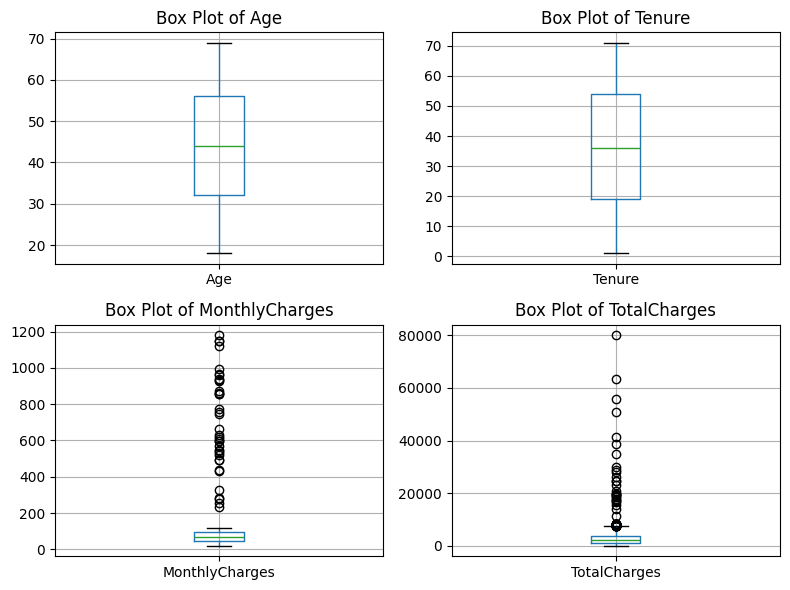

In [13]:
numerical_columns = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(8, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    dataset.boxplot(column=column)
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

In [14]:
columns_to_clip = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

for column in columns_to_clip:
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[column] = np.clip(dataset[column], lower_bound, upper_bound)

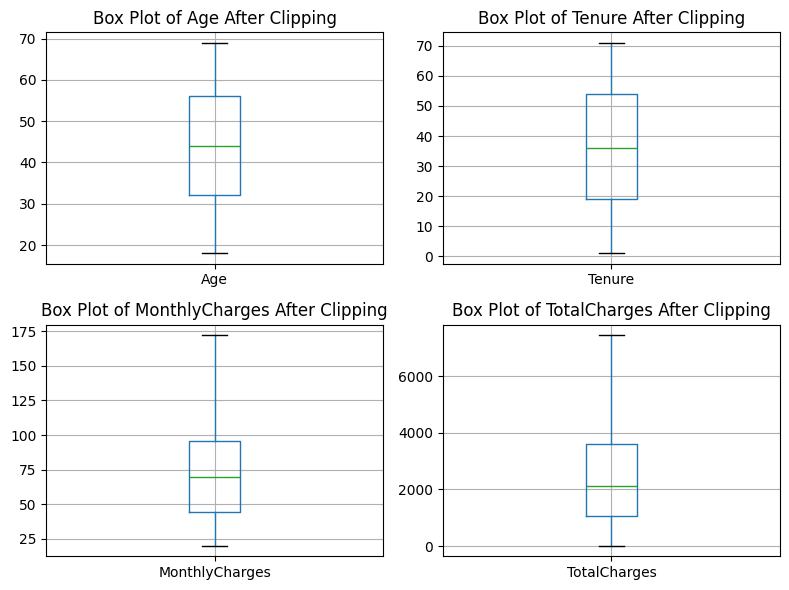

In [15]:
plt.figure(figsize=(8, 6))

for i, column in enumerate(columns_to_clip, 1):
    plt.subplot(2, 2, i)
    dataset.boxplot(column=column)
    plt.title(f'Box Plot of {column} After Clipping')

plt.tight_layout()
plt.show()

#EDA

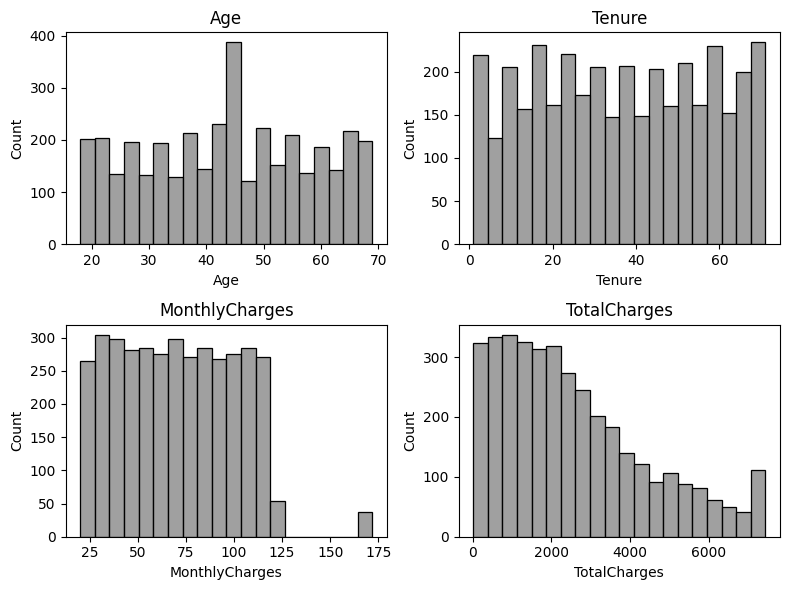

In [16]:
numerical_columns = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(8, 6))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(dataset[column], bins=20, color='gray')
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

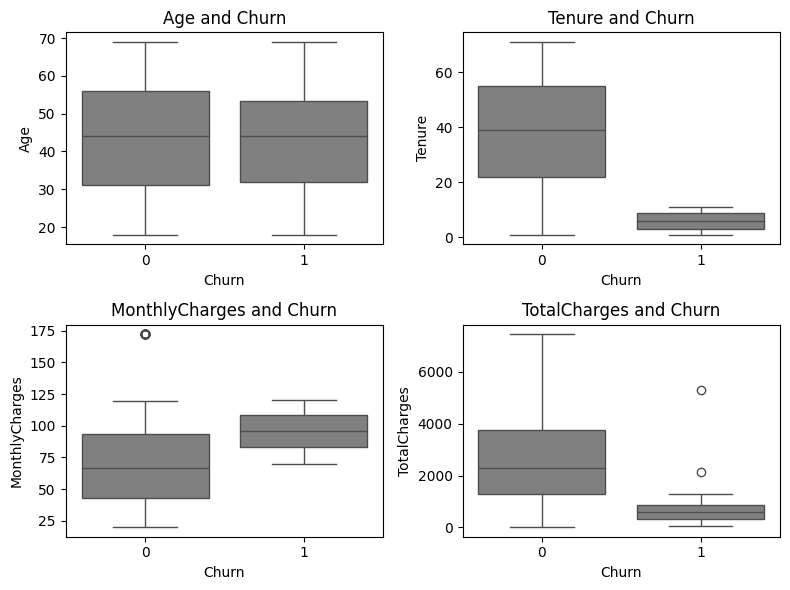

In [17]:
numerical_columns = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(8, 6))

for i, col in enumerate(numerical_columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='Churn', y=col, data=dataset, color='gray')
    plt.title(f'{col} and Churn')
    plt.tight_layout()

plt.show()

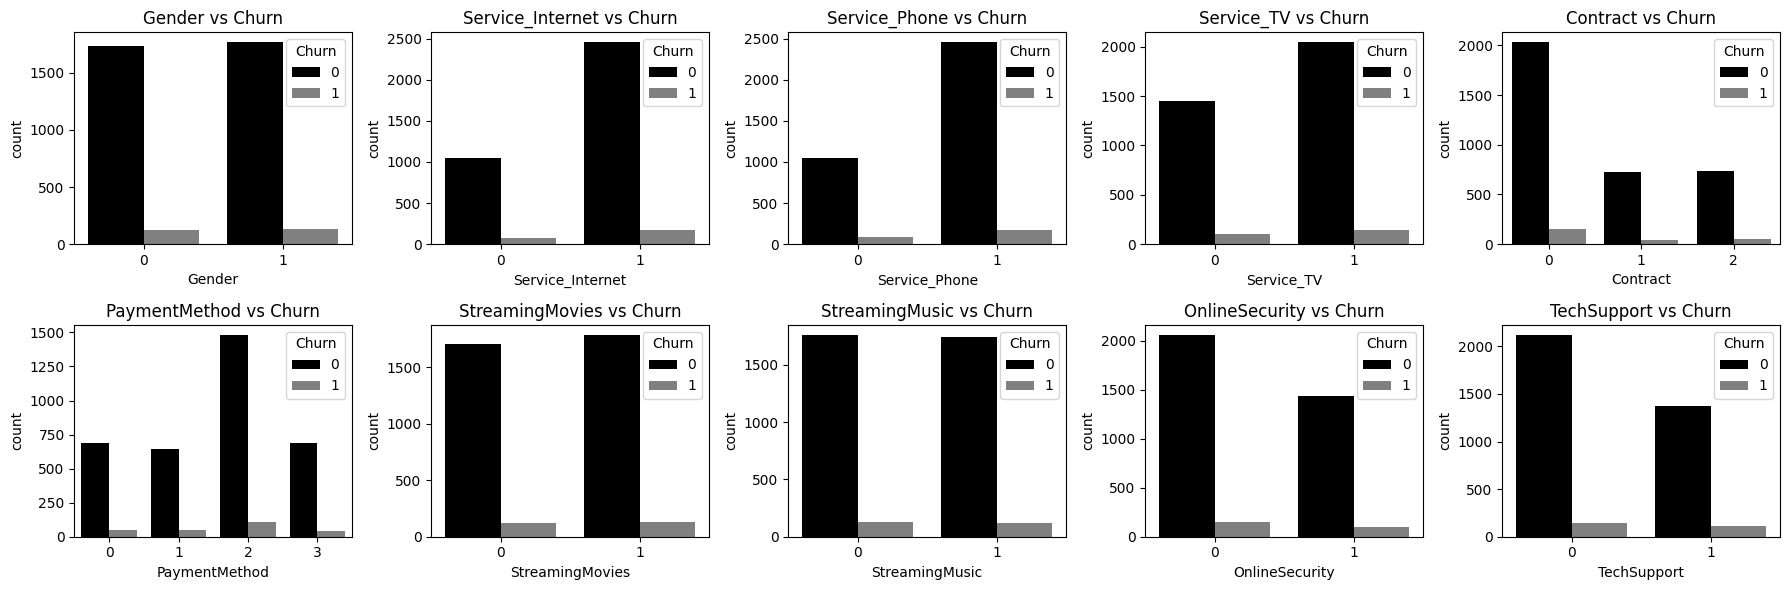

In [18]:
cats = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV', 'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic', 'OnlineSecurity', 'TechSupport']

plt.figure(figsize=(18, 6))

for i, col in enumerate(cats):
    plt.subplot(2, 5, i + 1)
    sns.countplot(x=col, hue='Churn', data=dataset, palette=['black', 'gray'])
    plt.title(f'{col} vs Churn')

plt.tight_layout()
plt.show()

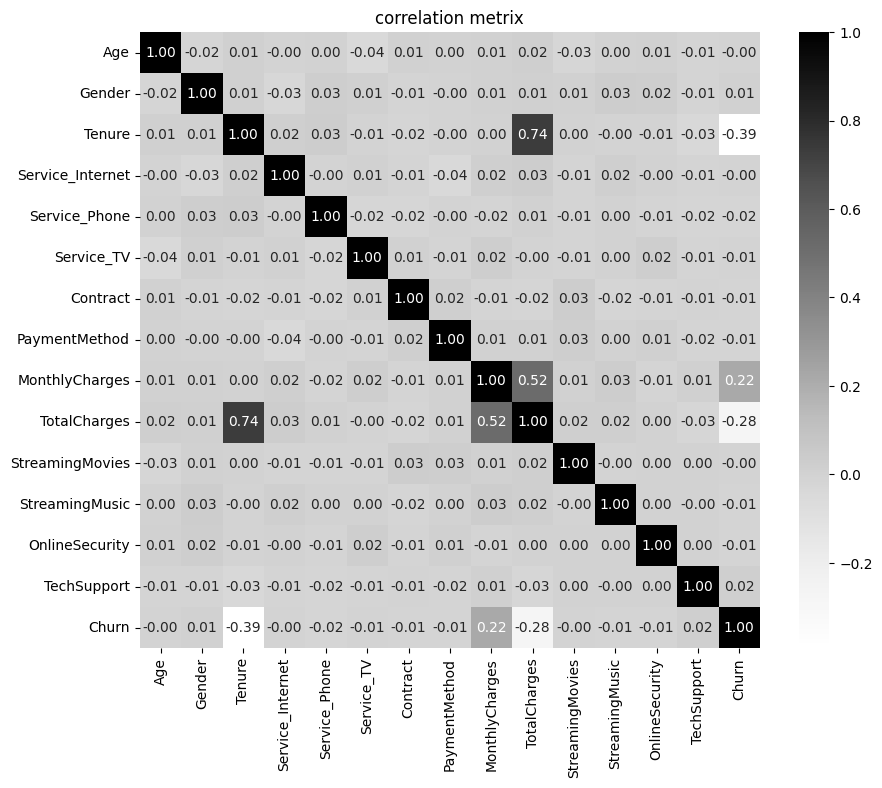

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(dataset.corr(), annot=True, cmap='Greys', fmt=".2f")
plt.title('correlation metrix')
plt.show()

In [20]:
X_categorical = dataset[['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV',
                         'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic',
                         'OnlineSecurity', 'TechSupport']]
Y = dataset['Churn']

chi_scores, p_values = chi2(X_categorical, Y)

chi_square_results = pd.DataFrame({
    'Feature': X_categorical.columns,
    'Chi-Square Score': chi_scores,
    'p-value': p_values
}).sort_values(by='p-value')

print("Chi-Square Test Results for Categorical Features:")
print(chi_square_results)

Chi-Square Test Results for Categorical Features:
            Feature  Chi-Square Score   p-value
9       TechSupport          0.780247  0.377065
4          Contract          0.534231  0.464834
2     Service_Phone          0.439102  0.507556
8    OnlineSecurity          0.339420  0.560164
5     PaymentMethod          0.229804  0.631669
7    StreamingMusic          0.171462  0.678816
0            Gender          0.082627  0.773768
3        Service_TV          0.045332  0.831394
6   StreamingMovies          0.036121  0.849267
1  Service_Internet          0.024715  0.875080


#Feature engineering

In [21]:
new_dataset = dataset.copy()

new_dataset['TotalServices'] = (new_dataset['Service_Internet'] + new_dataset['Service_Phone'] + new_dataset['Service_TV'] + new_dataset['OnlineSecurity'] + new_dataset['TechSupport'])

new_dataset['CLV'] = new_dataset['MonthlyCharges'] * new_dataset['Tenure']

new_dataset['AvgMonthlyChargeOverTenure'] = new_dataset['TotalCharges'] / (new_dataset['Tenure'] + 1)

new_dataset['RecentPaymentDrop'] = new_dataset['MonthlyCharges'] / new_dataset['AvgMonthlyChargeOverTenure']

In [22]:
new_dataset.to_csv('new_dataset.csv', index=False, sep=';')

In [23]:
new_dataset.head()

Age  Gender  Tenure  Service_Internet  Service_Phone  Service_TV  \
0  56.0       1      13                 0              1           0   
1  69.0       1      13                 0              0           1   
2  46.0       1      60                 1              0           1   
3  32.0       0      57                 1              1           1   
4  60.0       1      52                 1              1           1   

   Contract  PaymentMethod  MonthlyCharges  TotalCharges  StreamingMovies  \
0         1              3           71.88        931.49                0   
1         2              3          110.99       1448.46                1   
2         0              3          116.74       6997.73                1   
3         0              0           78.16       4452.13                0   
4         2              2           30.33       1569.73                1   

   StreamingMusic  OnlineSecurity  TechSupport  Churn  TotalServices      CLV  \
0               0               1            0      0              2   934.44   
1               1               0            0      0              1  1442.87   
2               1               0            0      0              2  7004.40   
3               1               0            1      0              4  4455.12   
4               0               1            1      0              5  1577.16   

   AvgMonthlyChargeOverTenure  RecentPaymentDrop  
0                   66.535000           1.080334  
1                  103.461429           1.072767  
2                  114.716885           1.017636  
3                   76.760862           1.018227  
4                   29.617547           1.024055

In [24]:
dataset.head()

Age  Gender  Tenure  Service_Internet  Service_Phone  Service_TV  \
0  56.0       1      13                 0              1           0   
1  69.0       1      13                 0              0           1   
2  46.0       1      60                 1              0           1   
3  32.0       0      57                 1              1           1   
4  60.0       1      52                 1              1           1   

   Contract  PaymentMethod  MonthlyCharges  TotalCharges  StreamingMovies  \
0         1              3           71.88        931.49                0   
1         2              3          110.99       1448.46                1   
2         0              3          116.74       6997.73                1   
3         0              0           78.16       4452.13                0   
4         2              2           30.33       1569.73                1   

   StreamingMusic  OnlineSecurity  TechSupport  Churn  
0               0               1            0      0  
1               1               0            0      0  
2               1               0            0      0  
3               1               0            1      0  
4               0               1            1      0

In [25]:
X = new_dataset.drop('Churn', axis=1)
Y = new_dataset['Churn']

X.head()

Age  Gender  Tenure  Service_Internet  Service_Phone  Service_TV  \
0  56.0       1      13                 0              1           0   
1  69.0       1      13                 0              0           1   
2  46.0       1      60                 1              0           1   
3  32.0       0      57                 1              1           1   
4  60.0       1      52                 1              1           1   

   Contract  PaymentMethod  MonthlyCharges  TotalCharges  StreamingMovies  \
0         1              3           71.88        931.49                0   
1         2              3          110.99       1448.46                1   
2         0              3          116.74       6997.73                1   
3         0              0           78.16       4452.13                0   
4         2              2           30.33       1569.73                1   

   StreamingMusic  OnlineSecurity  TechSupport  TotalServices      CLV  \
0               0               1            0              2   934.44   
1               1               0            0              1  1442.87   
2               1               0            0              2  7004.40   
3               1               0            1              4  4455.12   
4               0               1            1              5  1577.16   

   AvgMonthlyChargeOverTenure  RecentPaymentDrop  
0                   66.535000           1.080334  
1                  103.461429           1.072767  
2                  114.716885           1.017636  
3                   76.760862           1.018227  
4                   29.617547           1.024055

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Training Labels Shape:", Y_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Testing Labels Shape:", Y_test.shape)

Training Features Shape: (2999, 18)
Training Labels Shape: (2999,)
Testing Features Shape: (750, 18)
Testing Labels Shape: (750,)


In [27]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

In [28]:
pd.DataFrame(X_train_scaled).describe()

0             1             2             3             4   \
count  2.999000e+03  2.999000e+03  2.999000e+03  2.999000e+03  2.999000e+03   
mean  -4.916226e-17 -1.587408e-16  7.344723e-17 -4.264678e-17  8.884746e-17   
std    1.000167e+00  1.000167e+00  1.000167e+00  1.000167e+00  1.000167e+00   
min   -1.758926e+00 -1.015119e+00 -1.700798e+00 -1.545542e+00 -1.516321e+00   
25%   -8.678987e-01 -1.015119e+00 -8.782693e-01 -1.545542e+00 -1.516321e+00   
50%    2.312873e-02  9.851059e-01 -7.356825e-03  6.470221e-01  6.594909e-01   
75%    8.456156e-01  9.851059e-01  8.635557e-01  6.470221e-01  6.594909e-01   
max    1.736643e+00  9.851059e-01  1.686084e+00  6.470221e-01  6.594909e-01   

                 5             6             7             8             9   \
count  2.999000e+03  2.999000e+03  2.999000e+03  2.999000e+03  2.999000e+03   
mean  -6.515480e-18  1.658486e-17  7.463186e-17 -4.027751e-16 -1.895412e-17   
std    1.000167e+00  1.000167e+00  1.000167e+00  1.000167e+00  1.000167e+00   
min   -1.179639e+00 -7.660331e-01 -1.570092e+00 -1.661611e+00 -1.350829e+00   
25%   -1.179639e+00 -7.660331e-01 -5.878837e-01 -8.622067e-01 -7.883698e-01   
50%    8.477173e-01 -7.660331e-01  3.943243e-01 -3.530962e-02 -2.267347e-01   
75%    8.477173e-01  4.757687e-01  3.943243e-01  8.190798e-01  5.758051e-01   
max    8.477173e-01  1.717571e+00  1.376532e+00  3.313026e+00  2.619965e+00   

                 10            11            12            13            14  \
count  2.999000e+03  2.999000e+03  2.999000e+03  2.999000e+03  2.999000e+03   
mean  -1.563715e-16 -1.895412e-17 -1.184633e-17 -6.041627e-17 -8.943977e-17   
std    1.000167e+00  1.000167e+00  1.000167e+00  1.000167e+00  1.000167e+00   
min   -1.022596e+00 -9.916983e-01 -8.269737e-01 -8.116273e-01 -2.644458e+00   
25%   -1.022596e+00 -9.916983e-01 -8.269737e-01 -8.116273e-01 -7.467004e-01   
50%    9.779033e-01 -9.916983e-01 -8.269737e-01 -8.116273e-01  2.021786e-01   
75%    9.779033e-01  1.008371e+00  1.209228e+00  1.232093e+00  2.021786e-01   
max    9.779033e-01  1.008371e+00  1.209228e+00  1.232093e+00  2.099937e+00   

                 15            16            17  
count  2.999000e+03  2.999000e+03  2.999000e+03  
mean  -5.449311e-17 -2.215263e-16  5.923164e-17  
std    1.000167e+00  1.000167e+00  1.000167e+00  
min   -1.318585e+00 -1.663386e+00 -3.219414e+00  
25%   -7.755490e-01 -7.135433e-01 -2.199938e-01  
50%   -2.308772e-01 -4.666590e-02 -1.857733e-01  
75%    5.552026e-01  6.260120e-01 -9.291055e-02  
max    5.033707e+00  1.869752e+01  2.068127e+01

In [29]:
pd.DataFrame(X_test_scaled).describe()

0           1           2           3           4           5   \
count  750.000000  750.000000  750.000000  750.000000  750.000000  750.000000   
mean     0.003480   -0.020341    0.027093   -0.039981    0.024154    0.017853   
std      0.982011    1.000766    0.959718    1.017697    0.989963    0.997538   
min     -1.758926   -1.015119   -1.700798   -1.545542   -1.516321   -1.179639   
25%     -0.799358   -1.015119   -0.781501   -1.545542   -1.516321   -1.179639   
50%      0.023129   -1.015119   -0.007357    0.647022    0.659491    0.847717   
75%      0.828480    0.985106    0.863556    0.647022    0.659491    0.847717   
max      1.736643    0.985106    1.686084    0.647022    0.659491    0.847717   

               6           7           8           9           10          11  \
count  750.000000  750.000000  750.000000  750.000000  750.000000  750.000000   
mean     0.075081    0.080018   -0.013652    0.052190   -0.009010    0.000336   
std      1.026621    0.962470    0.982197    1.027258    1.000828    1.000670   
min     -0.766033   -1.570092   -1.656048   -1.337239   -1.022596   -0.991698   
25%     -0.766033   -0.587884   -0.854024   -0.766038   -1.022596   -0.991698   
50%     -0.766033    0.394324   -0.061329   -0.184072    0.977903   -0.991698   
75%      0.475769    0.394324    0.792897    0.601378    0.977903    1.008371   
max      1.717571    1.376532    3.313026    2.619965    0.977903    1.008371   

               12          13          14          15          16          17  
count  750.000000  750.000000  750.000000  750.000000  750.000000  750.000000  
mean     0.030946   -0.007764    0.012403    0.033036    0.014290   -0.038945  
std      1.006092    0.999002    1.028517    1.021594    0.950309    1.014451  
min     -0.826974   -0.811627   -2.644458   -1.308612   -1.437780   -3.222476  
25%     -0.826974   -0.811627   -0.746700   -0.754130   -0.673946   -0.220380  
50%     -0.826974   -0.811627    0.202179   -0.199617   -0.064786   -0.189390  
75%      1.209228    1.232093    1.151058    0.552039    0.655980   -0.116070  
max      1.209228    1.232093    2.099937    4.944090   10.759390   19.190869

In [30]:
def train_evaluate_plot(model, model_name, X_train_scaled, X_test_scaled, Y_train, Y_test):
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)

    print(f'{model_name} accuracy: {accuracy_score(Y_test, Y_pred):.4f}')

    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        print(f'{model_name} ROC-AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}\n')

    print(classification_report(Y_test, Y_pred))

    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='Greys')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

Logistic Regression accuracy: 0.9827
Logistic Regression ROC-AUC: 0.9954

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       707
           1       0.86      0.84      0.85        43

    accuracy                           0.98       750
   macro avg       0.92      0.91      0.92       750
weighted avg       0.98      0.98      0.98       750



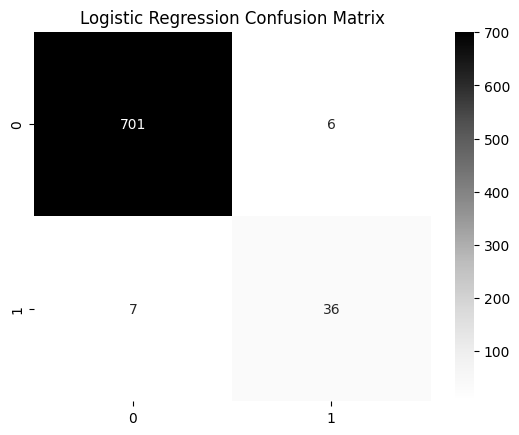

In [31]:
# Logistic Regression
train_evaluate_plot(LogisticRegression(random_state=42), "Logistic Regression", X_train_scaled, X_test_scaled, Y_train, Y_test)

Decision Tree accuracy: 0.9987
Decision Tree ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



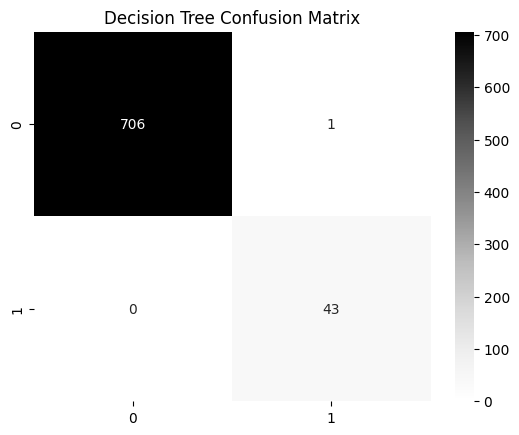

In [32]:
# Decision Tree
train_evaluate_plot(DecisionTreeClassifier(random_state=42), "Decision Tree", X_train_scaled, X_test_scaled, Y_train, Y_test)

Random Forest accuracy: 0.9987
Random Forest ROC-AUC: 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



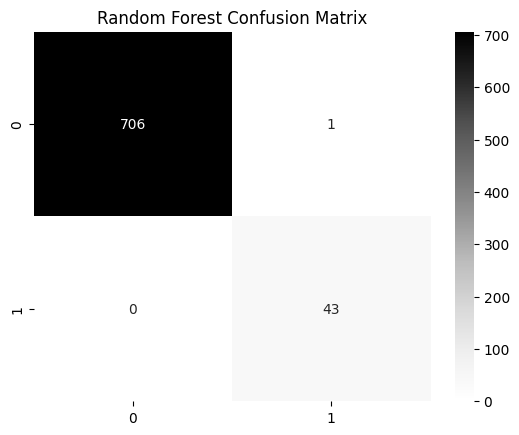

In [33]:
# Random Forest
train_evaluate_plot(RandomForestClassifier(random_state=42), "Random Forest", X_train_scaled, X_test_scaled, Y_train, Y_test)

Gradient Boosting accuracy: 0.9987
Gradient Boosting ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



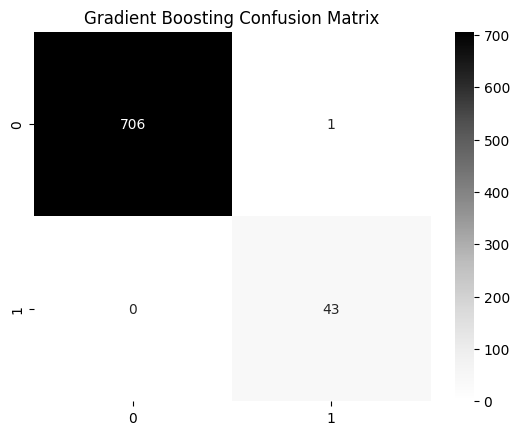

In [34]:
# Gradient Boosting
train_evaluate_plot(GradientBoostingClassifier(random_state=42), "Gradient Boosting", X_train_scaled, X_test_scaled, Y_train, Y_test)

In [35]:
pickle.dump(LogisticRegression, open('/content/drive/MyDrive/models/logistic_regression.pkl', 'wb'))
pickle.dump(DecisionTreeClassifier, open('/content/drive/MyDrive/models/decision_tree.pkl', 'wb'))
pickle.dump(RandomForestClassifier, open('/content/drive/MyDrive/models/random_forest.pkl', 'wb'))
pickle.dump(GradientBoostingClassifier, open('/content/drive/MyDrive/models/gradient_boosting.pkl', 'wb'))

In [36]:
param_grid_logistic = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200]
}

param_grid_decision_tree = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_random_forest = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gradient_boosting = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [37]:
def grid_search_eval(model_name, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled, Y_train)

    best_model = grid_search.best_estimator_
    Y_pred = best_model.predict(X_test_scaled)

    print(f"{model_name} Best params: {grid_search.best_params_}")
    print(f"Best CV accuracy: {grid_search.best_score_:.2f}")
    print(f"Test accuracy: {accuracy_score(Y_test, Y_pred):.4f}")

    if hasattr(best_model, "predict_proba"):
        Y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        print(f"ROC-AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}\n")

    print(classification_report(Y_test, Y_pred))
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap="Greys")
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return best_model

Logistic Regression Best params: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Best CV accuracy: 0.98
Test accuracy: 0.9840
ROC-AUC: 0.9961

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       707
           1       0.86      0.86      0.86        43

    accuracy                           0.98       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.98      0.98      0.98       750



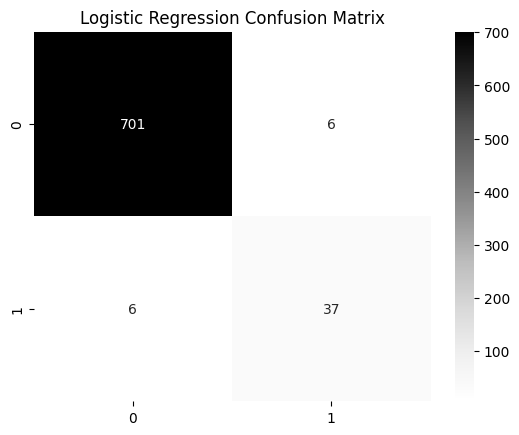

In [38]:
best_logistic_regression = grid_search_eval("Logistic Regression",LogisticRegression(random_state=42),param_grid_logistic)

Decision Tree Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 1.00
Test accuracy: 0.9987
ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



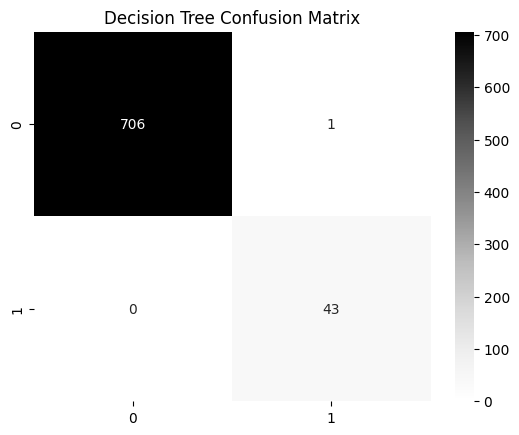

In [39]:
best_decision_tree = grid_search_eval("Decision Tree",DecisionTreeClassifier(random_state=42),param_grid_decision_tree)

Random Forest Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV accuracy: 1.00
Test accuracy: 0.9987
ROC-AUC: 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



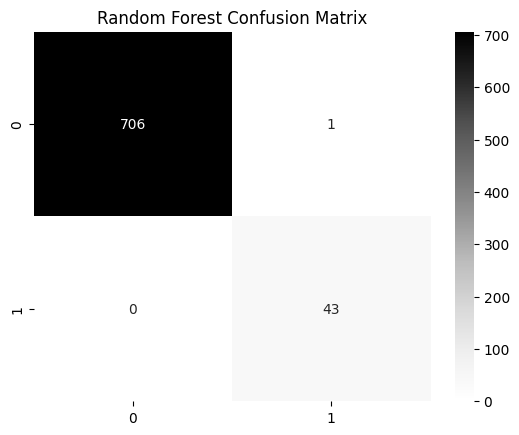

In [40]:
best_random_forest = grid_search_eval("Random Forest",RandomForestClassifier(random_state=42),param_grid_random_forest)

Gradient Boosting Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 1.00
Test accuracy: 0.9987
ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



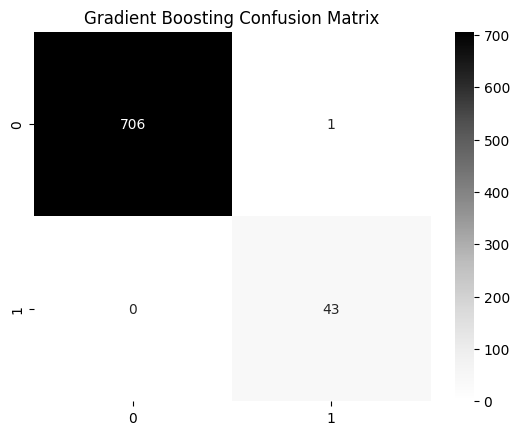

In [41]:
best_gradient_boosting = grid_search_eval("Gradient Boosting",GradientBoostingClassifier(random_state=42),param_grid_gradient_boosting)

In [42]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d571ee73e43daa1abd15ab152102e6f497509be37510514c3e278d14992a9905
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [43]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

In [44]:
sample_instance = X_test_scaled[0]

exp = explainer.explain_instance(
    data_row=sample_instance,
    predict_fn=best_logistic_regression.predict_proba
)

print('Logistic Regression')
exp.show_in_notebook(show_table=True)

Logistic Regression


In [45]:
sample_instance = X_test_scaled[0]

exp = explainer.explain_instance(
    data_row=sample_instance,
    predict_fn=best_decision_tree.predict_proba
)

print('Decision Tree')
exp.show_in_notebook(show_table=True)

Decision Tree


In [46]:
sample_instance = X_test_scaled[0]

exp = explainer.explain_instance(
    data_row=sample_instance,
    predict_fn=best_random_forest.predict_proba
)

print('Random Forest')
exp.show_in_notebook(show_table=True)

Random Forest


In [47]:
sample_instance = X_test_scaled[0]

exp = explainer.explain_instance(
    data_row=sample_instance,
    predict_fn=best_gradient_boosting.predict_proba
)

print('Gradient Boosting')
exp.show_in_notebook(show_table=True)

Gradient Boosting


In [48]:
best_logistic_regression.fit(X_train_scaled, Y_train)
print("Logistic Regression Feature Coefficients")
for coef, name in sorted(zip(best_logistic_regression.coef_[0], X.columns),reverse=True):
    print(f"{round(coef, 5)} {name}")

Logistic Regression Feature Coefficients
5.98187 MonthlyCharges
4.36535 Tenure
0.5487 AvgMonthlyChargeOverTenure
0.11675 Gender
0.1107 Age
0.05629 Service_Internet
0.05002 Contract
0.03029 StreamingMovies
0.02752 OnlineSecurity
0.02507 Service_Phone
0.01993 PaymentMethod
-0.00188 TechSupport
-0.06467 TotalServices
-0.09601 StreamingMusic
-0.23911 Service_TV
-1.00897 RecentPaymentDrop
-6.08876 TotalCharges
-13.78964 CLV


In [49]:
best_decision_tree.fit(X_train_scaled, Y_train)
print("Decision Tree Feature Importances")
for score, name in sorted(zip(best_decision_tree.feature_importances_, X.columns),reverse=True):
    print(f"{round(score, 5)} {name}")

Decision Tree Feature Importances
0.58223 MonthlyCharges
0.41777 Tenure
0.0 TotalServices
0.0 TotalCharges
0.0 TechSupport
0.0 StreamingMusic
0.0 StreamingMovies
0.0 Service_TV
0.0 Service_Phone
0.0 Service_Internet
0.0 RecentPaymentDrop
0.0 PaymentMethod
0.0 OnlineSecurity
0.0 Gender
0.0 Contract
0.0 CLV
0.0 AvgMonthlyChargeOverTenure
0.0 Age


In [50]:
best_random_forest.fit(X_train_scaled, Y_train)
print("Random Forest Feature Importances")
for score, name in sorted(zip(best_random_forest.feature_importances_, X.columns),reverse=True):
    print(f"{round(score, 5)} {name}")

Random Forest Feature Importances
0.24104 Tenure
0.23833 MonthlyCharges
0.1638 AvgMonthlyChargeOverTenure
0.15951 RecentPaymentDrop
0.09719 CLV
0.07946 TotalCharges
0.00609 Age
0.00268 TotalServices
0.00205 PaymentMethod
0.0015 Contract
0.00122 StreamingMovies
0.00116 Service_TV
0.00115 TechSupport
0.00113 StreamingMusic
0.0011 Service_Phone
0.001 OnlineSecurity
0.0009 Service_Internet
0.00069 Gender


In [51]:
best_gradient_boosting.fit(X_train_scaled, Y_train)
print("Gradient Boosting Feature Importances")
for score, name in sorted(zip(best_gradient_boosting.feature_importances_, X.columns),reverse=True):
    print(f"{round(score, 5)} {name}")

Gradient Boosting Feature Importances
0.58223 MonthlyCharges
0.41777 Tenure
0.0 AvgMonthlyChargeOverTenure
0.0 Age
0.0 RecentPaymentDrop
0.0 CLV
0.0 TotalServices
0.0 TechSupport
0.0 StreamingMusic
0.0 StreamingMovies
0.0 Service_TV
0.0 Service_Phone
0.0 Service_Internet
0.0 PaymentMethod
0.0 OnlineSecurity
0.0 Gender
0.0 Contract
-0.0 TotalCharges


In [52]:
pickle.dump(best_logistic_regression, open('/content/drive/MyDrive/tuned_models/best_logistic_regression.pkl', 'wb'))
pickle.dump(best_decision_tree, open('/content/drive/MyDrive/tuned_models/best_decision_tree.pkl', 'wb'))
pickle.dump(best_random_forest, open('/content/drive/MyDrive/tuned_models/best_random_forest.pkl', 'wb'))
pickle.dump(best_gradient_boosting, open('/content/drive/MyDrive/tuned_models/best_gradient_boosting.pkl', 'wb'))